<a href="https://colab.research.google.com/github/abhigyan2003/keystroke/blob/main/State_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo pandas scikit-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [22]:
import pandas as pd

# Load session files
u7_s1 = pd.read_csv("session_0041905381.csv")
u7_s2 = pd.read_csv("session_1060325796.csv")
u9_s1 = pd.read_csv("session_0335985747.csv")
u9_s2 = pd.read_csv("session_3390119815.csv")

# Add user labels
u7_s1["User"] = 7
u7_s2["User"] = 7
u9_s1["User"] = 9
u9_s2["User"] = 9

# Combine all data
df = pd.concat([u7_s1, u7_s2, u9_s1, u9_s2], ignore_index=True)
print(df["state"].unique())  # Check the unique states

['Move' 'Pressed' 'Released' 'Drag']


In [23]:
from sklearn.preprocessing import LabelEncoder

le_state = LabelEncoder()
df["StateEncoded"] = le_state.fit_transform(df["state"])
df["UserEncoded"] = df["User"].map({7: 0, 9: 1})  # Binary classification

print(df[["state", "StateEncoded"]].drop_duplicates())  # Sanity check


        state  StateEncoded
0        Move             1
44    Pressed             2
45   Released             3
114      Drag             0


In [24]:
SEQ_LEN = 50
X, y = [], []

for i in range(len(df) - SEQ_LEN):
    state_seq = df["StateEncoded"].iloc[i:i+SEQ_LEN].tolist()
    user_seq = df["UserEncoded"].iloc[i+SEQ_LEN - 1]  # label from the last step
    X.append(state_seq)
    y.append(user_seq)

import numpy as np
X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}, y: {y.shape}")

Shape of X: (226985, 50), y: (226985,)


In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

X_tensor = torch.tensor(X, dtype=torch.long)  # Long because it's categorical
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

In [26]:
print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))


Training samples: 181588
Validation samples: 45397


In [27]:
# Convert to numpy for easy class counts
train_labels = [y_tensor[i].item() for i in train_ds.indices]
val_labels = [y_tensor[i].item() for i in val_ds.indices]

# Print class distributions
from collections import Counter

print("Train class distribution:", Counter(train_labels))
print("Validation class distribution:", Counter(val_labels))

Train class distribution: Counter({0: 94612, 1: 86976})
Validation class distribution: Counter({0: 23773, 1: 21624})


In [28]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming y is your label array (already built during sequence prep)
class_weights_np = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights_np, dtype=torch.float)
print("Class Weights:", class_weights)


Class Weights: tensor([0.9587, 1.0451])


In [29]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -math.log(10000.0) / d_model)
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        # q: (batch, head, seq_len_q, d_k)
        # k: (batch, head, seq_len_k, d_k)
        # v: (batch, head, seq_len_v, d_v)

        # Scaled dot product
        attn = torch.matmul(q, k.transpose(2, 3)) / self.temperature

        # Apply mask (optional)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))  # better for stability

        # Softmax along last dimension (seq_len_k) for each query
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        # Weighted sum of values
        output = torch.matmul(attn, v)

        return output, attn

In [31]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        # Linear layers for projecting input to Q, K, V
        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)

        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        # Scaled dot-product attention
        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        bsz, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        # Save residual
        residual = q

        # Linear projections and reshape for multi-head
        q = self.w_qs(q).view(bsz, len_q, n_head, d_k).transpose(1, 2)  # (bsz, n_head, len_q, d_k)
        k = self.w_ks(k).view(bsz, len_k, n_head, d_k).transpose(1, 2)
        v = self.w_vs(v).view(bsz, len_v, n_head, d_v).transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)  # broadcast mask to all heads

        # Apply attention on all the projected vectors
        q, attn = self.attention(q, k, v, mask=mask)

        # Concatenate heads and put through final linear layer
        q = q.transpose(1, 2).contiguous().view(bsz, len_q, -1)
        q = self.dropout(self.fc(q))
        q = self.layer_norm(q + residual)  # Add & Norm

        return q, attn

In [32]:
class PositionwiseFeedForward(nn.Module):
    ''' Feed Forward layer used inside each encoder/decoder block '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)

    def forward(self, x):
        residual = x
        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x = self.layer_norm(x + residual)
        return x

In [33]:
class EncoderLayer(nn.Module):
    ''' One Encoder Layer = Multi-head Attention + Feed Forward '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super().__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        # Apply self-attention
        enc_output, enc_slf_attn = self.slf_attn(enc_input, enc_input, enc_input, mask=slf_attn_mask)

        # Apply position-wise feed-forward
        enc_output = self.pos_ffn(enc_output)

        return enc_output, enc_slf_attn

In [34]:
import torch
import torch.nn as nn

class MouseDynamicsClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes=2, d_model=64, num_heads=4, num_layers=2, d_inner=128, dropout=0.1, max_len=50):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)  # NEW: Embed state integers
        self.pos_enc = PositionalEncoding(d_model, max_len=max_len)  # Positional encoding stays

        d_k = d_v = d_model // num_heads

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, d_inner, num_heads, d_k, d_v, dropout=dropout)
            for _ in range(num_layers)
        ])

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x: [B, seq_len] where each token is a state_id
        x = self.embedding(x)       # [B, seq_len, d_model]
        x = self.pos_enc(x)         # [B, seq_len, d_model]

        for layer in self.encoder_layers:
            x, _ = layer(x)         # [B, seq_len, d_model]

        x = x.mean(dim=1)           # [B, d_model]
        return self.classifier(x)   # [B, 2]


In [35]:
# 1. Import if not already
import torch.nn as nn
import torch

# 2. Move model to device (if not already done)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Initialize the model (pass vocab_size for state embeddings)
vocab_size = len(le_state.classes_)  # Number of unique states
model = MouseDynamicsClassifier(vocab_size=vocab_size, num_classes=2).to(device)

# 4. Define loss function using previously computed class_weights (make sure class_weights is a tensor on device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

# 5. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [36]:
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA Device Name: Tesla T4


In [37]:
from tqdm.auto import tqdm

def train(model, train_dl, val_dl, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # === Validation ===
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                predicted = preds.argmax(1)
                correct += (predicted == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        print(f"✅ Epoch {epoch+1} | Loss: {total_loss:.4f} | Val Acc: {acc:.2%}")


In [38]:
train(model, train_dl, val_dl, epochs=10)

Epoch 1/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 1 | Loss: 3707.7954 | Val Acc: 62.12%


Epoch 2/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 2 | Loss: 3663.7293 | Val Acc: 59.82%


Epoch 3/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 3 | Loss: 3645.4872 | Val Acc: 63.10%


Epoch 4/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 4 | Loss: 3635.6247 | Val Acc: 63.07%


Epoch 5/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 5 | Loss: 3628.7785 | Val Acc: 63.17%


Epoch 6/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 6 | Loss: 3621.8125 | Val Acc: 62.33%


Epoch 7/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 7 | Loss: 3623.5554 | Val Acc: 63.01%


Epoch 8/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 8 | Loss: 3616.6155 | Val Acc: 62.55%


Epoch 9/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 9 | Loss: 3613.3030 | Val Acc: 62.62%


Epoch 10/10:   0%|          | 0/5675 [00:00<?, ?it/s]

✅ Epoch 10 | Loss: 3611.1216 | Val Acc: 63.19%


🔍 Classification Report:
              precision    recall  f1-score   support

      User 7       0.68      0.55      0.61     23773
      User 9       0.59      0.72      0.65     21624

    accuracy                           0.63     45397
   macro avg       0.64      0.64      0.63     45397
weighted avg       0.64      0.63      0.63     45397



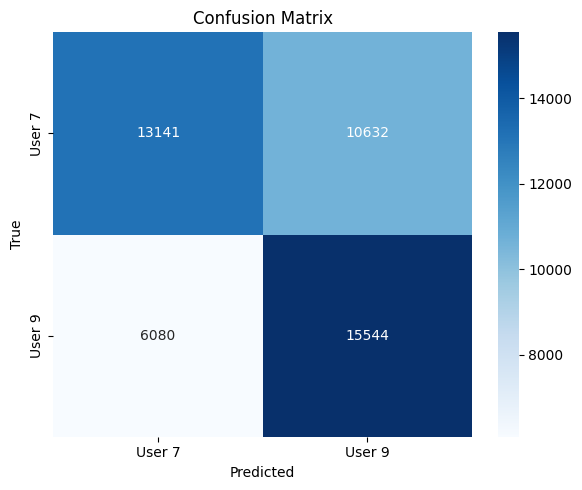

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()

# Store ground truth and predictions
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.argmax(1).cpu().tolist())

# Print classification report with proper class names
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["User 7", "User 9"]))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["User 7", "User 9"], yticklabels=["User 7", "User 9"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

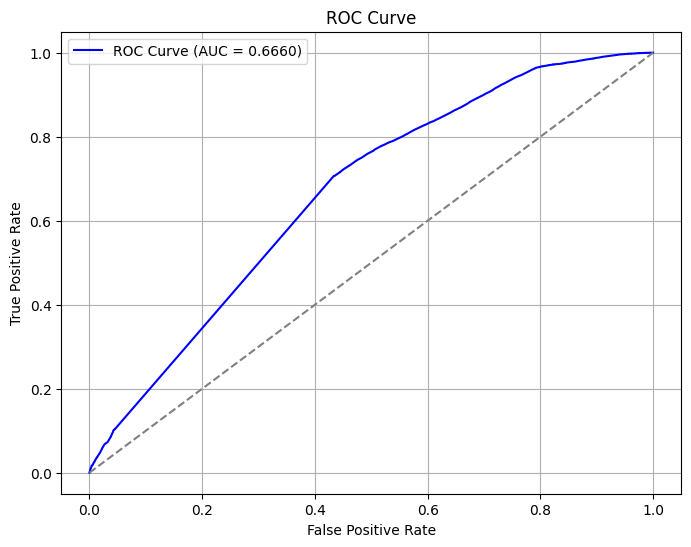

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_probs = []

model.eval()
with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.to(device)
        probs = torch.softmax(model(xb), dim=1)[:, 1]  # Probability for class 1 (User 9)
        y_probs.extend(probs.cpu().tolist())

# Compute AUC
auc = roc_auc_score(y_true, y_probs)

# Get FPR and TPR for the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], '--', color='gray')  # Diagonal line (random guessing)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()